### Install Libraries


In [1]:
#!mamba install pandas==1.3.3 -y
#!mamba install requests==2.26.0 -y
!mamba install bs4==4.10.0 -y
!mamba install html5lib==1.1 -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.15.3) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['bs4==4.10.0']

pkgs/main/linux-64       [<=>                 ] (00m:00s) 
pkgs/main/linux-64     

### Imports Libraries

In [2]:
from bs4 import BeautifulSoup
import html5lib
import requests
import pandas as pd
import urllib.request

# Part 1: API to Extract Exchange Rates

In [3]:
url = "https://api.apilayer.com/exchangerates_data/latest?base=EUR&apikey= " #YOU will need your own API Key here 
response = requests.get(url)
rates = response.json()
rates_df = pd.DataFrame(rates)

In [4]:
rates_df = rates_df[['rates']]
rates_df.head(5)

,rates
AED,3.917470
AFN,92.950963
ALL,114.650183
AMD,412.498113
ANG,1.915308


In [5]:
rates_df.to_csv('exchange_rates.csv')

In [6]:
exchange_rates = pd.read_csv('exchange_rates.csv')
GBP = exchange_rates[exchange_rates['Unnamed: 0'] == 'GBP']
GBP = GBP.iloc[0,1]
GBP

0.875497

In [7]:
USD = exchange_rates[exchange_rates['Unnamed: 0'] == 'USD']
USD = USD.iloc[0,1]
USD

1.066587

In [8]:
ARS = exchange_rates[exchange_rates['Unnamed: 0'] == 'ARS']
ARS = ARS.iloc[0,1]
ARS

216.871082

# Part 2: TRANSFERMARKT Site Webscrapping

### Imports Libraries

### Extract World Ranking

In [38]:
my_url = "https://www.transfermarkt.es/vereins-statistik/wertvollstenationalmannschaften/marktwertetop/"

# here we define the headers for the request
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}

# this request object will integrate your URL and the headers defined above
req = urllib.request.Request(url=my_url, headers=headers)

# calling urlopen this way will automatically handle closing the request
with urllib.request.urlopen(req) as response:
    page_html = response.read()
    
soup = BeautifulSoup(page_html, 'html.parser')

In [39]:
Ranking = pd.DataFrame(columns=["Posicion", "Pais", "Confederacion", "Valor", "link"])
Ranking

,Posicion,Pais,Confederacion,Valor,link


In [40]:
for row in soup.find_all('tbody')[1].find_all('tr'):
    link = row.find_all('td')
    data = row.find_all('td')
    if len(data) == 6:
        Posicion = data[0].text.strip()
        Pais = data[1].text.strip()
        Confederacion = data[4].text.strip()
        Valor = data[5].text.strip()
        link = row.find_all('a')
        link = link[0].get('href')
        Ranking = Ranking.append({"Posicion": Posicion, "Pais": Pais, "Confederacion": Confederacion, "Valor": Valor, "link": link}, ignore_index = True)

In [41]:
Ranking.head(8)

,Posicion,Pais,Confederacion,Valor,link
0,1,Inglaterra,UEFA,"1,26 mil mill. €",/england/startseite/verein/3299/saison_id/2022
1,2,Francia,UEFA,"1,04 mil mill. €",/frankreich/startseite/verein/3377/saison_id/2022
2,3,Portugal,UEFA,"913,00 mill. €",/portugal/startseite/verein/3300/saison_id/2022
3,4,España,UEFA,"863,00 mill. €",/spanien/startseite/verein/3375/saison_id/2022
4,5,Argentina,CONMEBOL,"846,20 mill. €",/argentinien/startseite/verein/3437/saison_id/...
5,6,Brasil,CONMEBOL,"761,40 mill. €",/brasilien/startseite/verein/3439/saison_id/2022
6,7,Alemania,UEFA,"716,70 mill. €",/deutschland/startseite/verein/3262/saison_id/...
7,8,Países Bajos,UEFA,"603,75 mill. €",/niederlande/startseite/verein/3379/saison_id/...


### Transform World Ranking

In [42]:
Ranking['Valor'] = Ranking['Valor'].replace(' mill. €', '', regex=True)
Ranking['Valor'] = Ranking['Valor'].replace(' mil', '000', regex=True)
Ranking['Valor'] = Ranking['Valor'].replace(',', '', regex=True)
Ranking['Valor'] = Ranking['Valor'].astype(int)
Ranking['Valor'] = Ranking['Valor']/100
Ranking['Valor'] = round(Ranking['Valor'])
Ranking['link']  = "https://www.transfermarkt.es" + Ranking['link']

In [43]:
Ranking.head(8)

,Posicion,Pais,Confederacion,Valor,link
0,1,Inglaterra,UEFA,1260.0,https://www.transfermarkt.es/england/startseit...
1,2,Francia,UEFA,1040.0,https://www.transfermarkt.es/frankreich/starts...
2,3,Portugal,UEFA,913.0,https://www.transfermarkt.es/portugal/startsei...
3,4,España,UEFA,863.0,https://www.transfermarkt.es/spanien/startseit...
4,5,Argentina,CONMEBOL,846.0,https://www.transfermarkt.es/argentinien/start...
5,6,Brasil,CONMEBOL,761.0,https://www.transfermarkt.es/brasilien/startse...
6,7,Alemania,UEFA,717.0,https://www.transfermarkt.es/deutschland/start...
7,8,Países Bajos,UEFA,604.0,https://www.transfermarkt.es/niederlande/start...


### Extract National Teams

In [44]:
National_Teams = pd.DataFrame(columns=["National_Team", "Numero", "Nombre", "Posicion", "Edad", "Valor", "Club"])
url = Ranking['link']
Nat_Team = Ranking['Pais']

for i in range(len(url)):
    my_url = url[i]
    National_Team = Nat_Team[i]
    print(my_url)
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
    req = urllib.request.Request(url=my_url, headers=headers)
    with urllib.request.urlopen(req) as response:
        page_html = response.read()
    soup = BeautifulSoup(page_html, 'html.parser')
    for row in soup.find_all('tbody')[1].find_all('tr'):
        data = row.find_all('td')
        club = row.find_all('td')
        if len(data) == 9:
            Numero   = data[0].text.strip()
            Nombre   = data[5].text.strip()
            Posicion = data[4].text.strip()
            Edad     = data[6].text.strip()
            Valor    = data[8].text.strip()
            club = club[7]
            club = club.find_all('a')
            club = club[0]
            club = club.get('title')
            ##print(club)
            National_Teams = National_Teams.append({"National_Team": National_Team, "Numero": Numero, "Nombre": Nombre, "Posicion": Posicion, "Edad": Edad, "Valor": Valor, "Club" : club}, ignore_index = True)

https://www.transfermarkt.es/england/startseite/verein/3299/saison_id/2022
https://www.transfermarkt.es/frankreich/startseite/verein/3377/saison_id/2022
https://www.transfermarkt.es/portugal/startseite/verein/3300/saison_id/2022
https://www.transfermarkt.es/spanien/startseite/verein/3375/saison_id/2022
https://www.transfermarkt.es/argentinien/startseite/verein/3437/saison_id/2022
https://www.transfermarkt.es/brasilien/startseite/verein/3439/saison_id/2022
https://www.transfermarkt.es/deutschland/startseite/verein/3262/saison_id/2022
https://www.transfermarkt.es/niederlande/startseite/verein/3379/saison_id/2022
https://www.transfermarkt.es/italien/startseite/verein/3376/saison_id/2022
https://www.transfermarkt.es/belgien/startseite/verein/3382/saison_id/2022
https://www.transfermarkt.es/uruguay/startseite/verein/3449/saison_id/2022
https://www.transfermarkt.es/norwegen/startseite/verein/3440/saison_id/2022
https://www.transfermarkt.es/serbien/startseite/verein/3438/saison_id/2022
https:

In [45]:
National_Teams['Valor'] = National_Teams['Valor'].replace(' mill. €', '0000', regex=True)
National_Teams['Valor'] = National_Teams['Valor'].replace(' mil €', '000', regex=True)
National_Teams['Valor'] = National_Teams['Valor'].replace(',', '', regex=True)
National_Teams          = National_Teams[National_Teams['Valor'].str.contains("0")]
##National_Teams['Valor'][380] = '0'
##National_Teams['Valor'][407] = '0'
National_Teams['Valor'] = National_Teams['Valor'].astype(int)

In [46]:
National_Teams['Valor (GBP)'] = National_Teams['Valor'] * GBP
National_Teams['Valor (USD)'] = National_Teams['Valor'] * USD
National_Teams['Valor (AR$)'] = National_Teams['Valor'] * ARS
National_Teams['Valor (EUR)'] = National_Teams['Valor']

In [47]:
National_Teams = National_Teams[['National_Team','Numero','Nombre','Posicion','Edad','Club','Valor (EUR)','Valor (GBP)', 'Valor (USD)','Valor (AR$)']]
National_Teams.head(10)

,National_Team,Numero,Nombre,Posicion,Edad,Club,Valor (EUR),Valor (GBP),Valor (USD),Valor (AR$)
0,Inglaterra,23,Aaron Ramsdale,Portero,24,Arsenal FC,38000000,33268886.0,40530306.0,8.241101e+09
1,Inglaterra,1,Jordan Pickford,Portero,29,Everton FC,25000000,21887425.0,26664675.0,5.421777e+09
2,Inglaterra,13,Nick Pope,Portero,30,Newcastle United,18000000,15758946.0,19198566.0,3.903679e+09
3,Inglaterra,-,Marc Guéhi,Defensa central,22,Crystal Palace,35000000,30642395.0,37330545.0,7.590488e+09
4,Inglaterra,5,John Stones,Defensa central,28,Manchester City,30000000,26264910.0,31997610.0,6.506132e+09
5,Inglaterra,6,Harry Maguire,Defensa central,30,Manchester United,25000000,21887425.0,26664675.0,5.421777e+09
6,Inglaterra,15,Eric Dier,Defensa central,29,Tottenham Hotspur,25000000,21887425.0,26664675.0,5.421777e+09
7,Inglaterra,-,Ben Chilwell,Lateral izquierdo,26,Chelsea FC,35000000,30642395.0,37330545.0,7.590488e+09
8,Inglaterra,3,Luke Shaw,Lateral izquierdo,27,Manchester United,35000000,30642395.0,37330545.0,7.590488e+09
9,Inglaterra,-,Reece James,Lateral derecho,23,Chelsea FC,70000000,61284790.0,74661090.0,1.518098e+10


In [48]:
National_Teams['Valor (EUR)'].sum()

12832075000

In [49]:
National_Teams['Valor (GBP)'].sum()

11234443166.275

In [50]:
National_Teams['Valor (USD)'].sum()

13686524378.025

In [51]:
National_Teams['Valor (AR$)'].sum()

2782905989555.15

### Data Loading

In [60]:
National_Teams.to_csv('transfermarket_extract.csv')

### Data Visualization

In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
Grouped_National_Teams = National_Teams.groupby(['National_Team'], as_index=False).sum()
Grouped_National_Teams = Grouped_National_Teams[['National_Team','Valor (EUR)']]
Grouped_National_Teams = Grouped_National_Teams.sort_values('Valor (EUR)', ascending=False)
Grouped_National_Teams_top8 = Grouped_National_Teams.head(8)
Grouped_National_Teams_top8

,National_Team,Valor (EUR)
12,Inglaterra,1261000000
11,Francia,1038000000
19,Portugal,913000000
9,España,863000000
1,Argentina,846200000
3,Brasil,761400000
0,Alemania,716700000
13,Italia,677000000


In [55]:
x = Grouped_National_Teams_top8['National_Team']
y = Grouped_National_Teams_top8['Valor (EUR)']

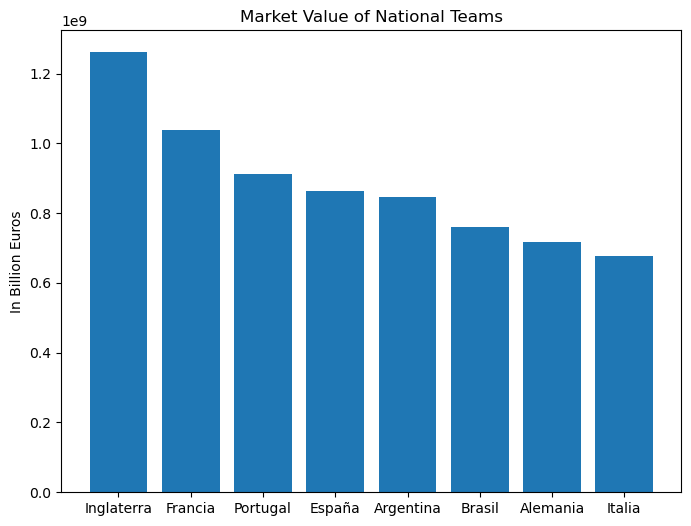

In [56]:
plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.ylabel("In Billion Euros")
plt.title("Market Value of National Teams")
plt.show()

In [57]:
National_Teams[National_Teams['National_Team']=='Argentina'].sort_values('Valor (EUR)', ascending=False).head(10)

,National_Team,Numero,Nombre,Posicion,Edad,Club,Valor (EUR),Valor (GBP),Valor (USD),Valor (AR$)
114,Argentina,24,Enzo Fernández,Mediocentro,22,Chelsea FC,85000000,74417245.0,90659895.0,1.843404e+10
129,Argentina,22,Lautaro Martínez,Delantero centro,25,Inter de Milán,75000000,65662275.0,79994025.0,1.626533e+10
100,Argentina,13,Cristian Romero,Defensa central,24,Tottenham Hotspur,60000000,52529820.0,63995220.0,1.301226e+10
124,Argentina,10,Lionel Messi,Extremo derecho,35,París Saint-Germain FC,50000000,43774850.0,53329350.0,1.084355e+10
130,Argentina,9,Julián Álvarez,Delantero centro,23,Manchester City,50000000,43774850.0,53329350.0,1.084355e+10
101,Argentina,25,Lisandro Martínez,Defensa central,25,Manchester United,50000000,43774850.0,53329350.0,1.084355e+10
115,Argentina,20,Alexis Mac Allister,Mediocentro,24,Brighton & Hove Albion,42000000,36770874.0,44796654.0,9.108585e+09
116,Argentina,7,Rodrigo de Paul,Mediocentro,28,Atlético de Madrid,40000000,35019880.0,42663480.0,8.674843e+09
125,Argentina,15,Ángel Correa,Extremo derecho,28,Atlético de Madrid,40000000,35019880.0,42663480.0,8.674843e+09
128,Argentina,21,Paulo Dybala,Mediapunta,29,AS Roma,30000000,26264910.0,31997610.0,6.506132e+09
